In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


%matplotlib inline	

## Pre-processing

In [2]:
columns = ['timestamp', 'arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8', 'attack']

df = pd.read_csv("post-attack-labeled/gear-attacks/force-neutral-1.csv", sep=",", index_col=None)

# Function to split each value into 8 bytes
def split_bytes(value):
    bytes_list = [value[i:i+2] for i in range(0, len(value), 2)]
    return bytes_list

# Apply the function to create new columns
df_bytes = df['data_field'].apply(split_bytes).apply(pd.Series)

# Rename columns
df_bytes.columns = [f'byte_{i+1}' for i in range(df_bytes.shape[1])]

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, df_bytes], axis=1)


# Drop data_field
df = df.drop(["data_field"], axis= 1)

# Set new order to columns with attack label last
df = df[columns]

# Convert from hex to decimal
for i in columns:
    if i == 'attack':
        continue
    df[i] = df[i].astype(str).dropna().apply(lambda x: float.fromhex(x))

# Replace NaN values with 0
df.fillna(0, inplace=True)

df = df.loc[:, ['arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8', 'attack']] # Remove labels

df

,arbitration_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,attack
0,328.0,11.0,17.0,83.0,136.0,65.0,0.0,102.0,5.0,0
1,554.0,218.0,44.0,0.0,0.0,48.0,255.0,127.0,0.0,0
2,329.0,22.0,12.0,63.0,40.0,170.0,29.0,0.0,0.0,0
3,320.0,0.0,8.0,86.0,8.0,35.0,35.0,35.0,160.0,0
4,2.0,255.0,246.0,112.0,5.0,106.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
527584,640.0,6.0,6.0,24.0,0.0,0.0,0.0,0.0,0.0,0
527585,641.0,136.0,128.0,68.0,252.0,80.0,0.0,0.0,0.0,0
527586,2.0,0.0,5.0,112.0,9.0,126.0,0.0,0.0,0.0,0
527587,881.0,0.0,0.0,1.0,32.0,11.0,207.0,255.0,32.0,0


In [3]:
df['attack'].value_counts()

attack
0    525869
1      1720
Name: count, dtype: int64

In [4]:
train_cols = ['arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8']

# Scale

In [5]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))
encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 
    else:
        if col == 'attack' or col == 'timestamp':
            continue 
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        encoder_map[col] = scaler 


# Train-test split

In [6]:
labels = df['attack']
# Conduct a train-test split    
x_train, x_test, y_train, y_test = train_test_split(df[train_cols].values, labels.values, test_size = 0.15, random_state = 42)

In [7]:
# Additional split of training dataset to create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [8]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(358760, 9)
y_train:(358760,)

x_val:(89690, 9)
y_val:(89690,)

x_test:(79139, 9)
y_test:(79139,)


In [9]:
# Split a set into 80% only normal data, and 20% normal data + any anomalies in set
def split_by_class(x, y):
    # Separate into normal, anomaly
    x_normal = x[y == 0]
    x_anom = x[y==1]
    
    y_normal = y[y==0]
    y_anom = y[y==1]
    
    # Split normal into 80-20 split, one for pure training and other for eval
    x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_normal, y_normal, test_size=0.2, random_state=42)
    
    # Combine the eval set with the anomalies to test outlier detection
    x_train_test = np.concatenate((x_train_test, x_anom))
    y_train_test = np.concatenate((y_train_test, y_anom))
    
    # Shuffle the eval set
    random_indices = np.random.choice(list(range(len(x_train_test))), size=len(x_train_test), replace=False)
    x_train_test = x_train_test[random_indices]
    y_train_test = y_train_test[random_indices]
    
    return x_train_train, x_train_test, y_train_train, y_train_test

In [10]:
### Train on normal data only. The _test splits have normal and anomaly data both
x_train_train, x_train_test, y_train_train, y_train_test = split_by_class(x_train, y_train)

In [11]:
x_train_test

array([[-0.22345877,  2.08874723,  0.1907138 , ..., -0.64635349,
        -0.52458091,  1.53096209],
       [-0.85066859,  2.20442194,  1.36252678, ...,  1.37176998,
        -0.49411198, -0.39414861],
       [-0.2742329 ,  0.29578925,  0.05009624, ...,  2.49119784,
        -0.52458091, -0.56089049],
       ...,
       [ 4.10727572, -0.66431083, -0.27801139, ..., -0.52022077,
         0.49612828, -0.59120719],
       [-0.2533259 , -0.57177107, -0.26238722, ..., -0.64635349,
         1.02933458, -0.51541543],
       [-0.17567135, -0.69901325, -0.59049486, ..., -0.64635349,
        -0.43317412, -0.59120719]])

In [12]:
print(f"x_train_train: {x_train_train.shape}")
print(f"y_train_train: {y_train_train.shape}")   
print(f"x_train_test: {x_train_test.shape}") 
print(f"y_train_test: {y_train_test.shape}") 

x_train_train: (286064, 9)
y_train_train: (286064,)
x_train_test: (72696, 9)
y_train_test: (72696,)


## One-Class SVM

In [13]:
# estimate proportion of anomalies
(y_test==1).sum() / len(y_test)

0.0032979946676101545

In [14]:
svm = OneClassSVM(nu=0.0065, gamma=0.05)
svm.fit(x_train_train[:200000])

OneClassSVM(gamma=0.05, nu=0.0065)

In [15]:
preds = svm.predict(x_train_test)
# -1 is < 0, so it flags as 1. 1 is > 0, so flags as 0.
preds = (preds < 0).astype(int) 
preds

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
pre = precision_score(y_train_test, preds )
rec = recall_score(y_train_test, preds)
f1 = f1_score(y_train_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")


Precision: 0.0
Recall: 0.0
F1-Measure: 0.0


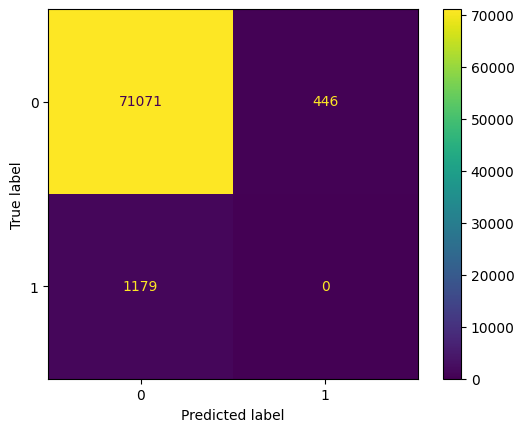

In [17]:
ConfusionMatrixDisplay(confusion_matrix(y_train_test, preds)).plot()

# Hyperparameter testing

### Gamma

In [18]:
def experiment(svm, x_train, y_train, x_test, y_test):
    
    # Fit on the training data, predict on the test
    svm.fit(x_train)
    
    preds = svm.predict(x_test)
    
    # Predictions are either -1 or 1
    preds = (preds < 0).astype(int)
    
    pre = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    return {'precision': pre, 'recall': rec, 'f1': f1}

In [19]:
validation_results = {}
gamma = [0.005, 0.05, 0.5]
for g in gamma:
    
    svm = OneClassSVM(nu=0.0065, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res
    
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.005, 0.0), (0.05, 0.0), (0.5, 0.0)]

In [20]:
validation_results = {}
gamma = [1, 5, 10, 15, 20, 100, 150, 200]
for g in gamma:
    g = g / 1000.0

    svm = OneClassSVM(nu=0.0065, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.001, 0.0),
 (0.005, 0.0),
 (0.01, 0.0),
 (0.015, 0.0),
 (0.02, 0.0),
 (0.1, 0.0),
 (0.15, 0.0),
 (0.2, 0.0)]

In [21]:
validation_results = {}
gamma = [0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018]
for g in gamma:

    svm = OneClassSVM(nu=0.0065, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.011, 0.0),
 (0.012, 0.0),
 (0.013, 0.0),
 (0.014, 0.0),
 (0.015, 0.0),
 (0.016, 0.0),
 (0.017, 0.0),
 (0.018, 0.0)]

### nu

In [23]:

validation_results = {}
nu = range(1, 10)
for n in nu:
    n = n / 1000.0

    svm = OneClassSVM(nu=n, gamma=0.016)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.001, 0.0),
 (0.002, 0.0),
 (0.003, 0.0),
 (0.004, 0.0),
 (0.005, 0.0),
 (0.006, 0.0),
 (0.007, 0.0),
 (0.008, 0.0),
 (0.009, 0.0)]

In [24]:
validation_results = {}
nu = [26, 27, 28, 29, 30, 31, 32, 33, 35, 35]
for n in nu:
    n = n / 10000.0

    svm = OneClassSVM(nu=n, gamma=0.016)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.0026, 0.0),
 (0.0027, 0.0),
 (0.0028, 0.0),
 (0.0029, 0.0),
 (0.003, 0.0),
 (0.0031, 0.0),
 (0.0032, 0.0),
 (0.0033, 0.0),
 (0.0035, 0.0)]

## Re-train model


In [25]:
svm = OneClassSVM(nu=0.003, gamma=0.016)
svm.fit(x_train_train[:200000])

OneClassSVM(gamma=0.016, nu=0.003)

In [26]:
preds = svm.predict(x_test)
preds = (preds < 0).astype(int)

In [27]:
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")

Precision: 0.0
Recall: 0.0
F1-Measure: 0.0


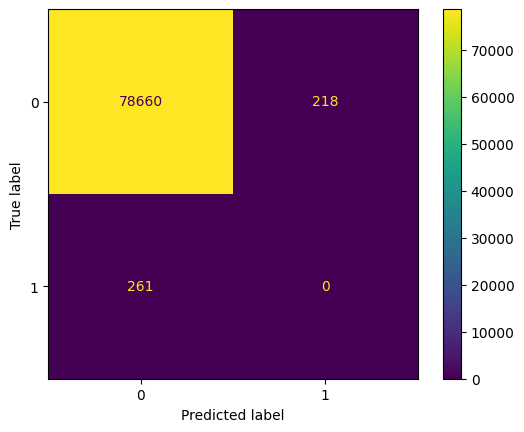

In [28]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()